# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [56]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import CountVectorizer

# Student added libraries :D
from IPython.display import Markdown, display
import pandas as pd

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [3]:
unique, counts = np.unique(train_labels, return_counts=True)

for key, count in zip(unique, counts):
    print("{:<20} :{}".format(newsgroups_train.target_names[key], count))

alt.atheism          :480
comp.graphics        :584
sci.space            :593
talk.religion.misc   :377


In [93]:
line_separator = "\n══════════════════════════════════════════════════════════════════════════════\n"

def pretty_print_message(label, message, predicted_label=None):
    out_string = ''
    if predicted_label:
        out_string+="**Predicted Label**: {}  \n".format(predicted_label)
    out_string+="**Label**: {}  \n".format(label)
    out_string+="**Text**:  \n   {}  \n".format(message)
    out_string+=line_separator
    display(Markdown(out_string))


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [123]:
def P1(num_examples=5):
### STUDENT START ###
    display(Markdown("## P1 ANSWER"))
    for x, y in zip(train_data[:5], train_labels[:5]):
        pretty_print_message(newsgroups_train.target_names[y], x)
        
### STUDENT END ###
P1()

## P1 ANSWER

**Label**: comp.graphics  
**Text**:  
   Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych  

══════════════════════════════════════════════════════════════════════════════


**Label**: talk.religion.misc  
**Text**:  
   

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.  

══════════════════════════════════════════════════════════════════════════════


**Label**: sci.space  
**Text**:  
   
 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) 

MB>                                                             So the
MB> 1970 figure seems unlikely to actually be anything but a perijove.

JG>Sorry, _perijoves_...I'm not used to talking this language.

Couldn't we just say periapsis or apoapsis?

   

══════════════════════════════════════════════════════════════════════════════


**Label**: alt.atheism  
**Text**:  
   I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themselves.  Between
the last two re-postings of the Challenges, I noted perhaps a dozen or
more posts by Mr. Wingate, none of which answered a single Challenge.  

It seems unmistakable to me that Mr. Wingate hopes that the questions
will just go away, and he is doing his level best to change the
subject.  Given that this seems a rather common net.theist tactic, I
would like to suggest that we impress upon him our desire for answers,
in the following manner:

1. Ignore any future articles by Mr. Wingate that do not address the
Challenges, until he answers them or explictly announces that he
refuses to do so.

--or--

2. If you must respond to one of his articles, include within it
something similar to the following:

    "Please answer the questions posed to you in the Charley Challenges."

Really, I'm not looking to humiliate anyone here, I just want some
honest answers.  You wouldn't think that honesty would be too much to
ask from a devout Christian, would you?  

Nevermind, that was a rhetorical question.  

══════════════════════════════════════════════════════════════════════════════


**Label**: sci.space  
**Text**:  
   AW&ST  had a brief blurb on a Manned Lunar Exploration confernce
May 7th  at Crystal City Virginia, under the auspices of AIAA.

Does anyone know more about this?  How much, to attend????

Anyone want to go?  

══════════════════════════════════════════════════════════════════════════════


(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [132]:
def P2():
### STUDENT START ###
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    vocabulary_size = X.shape[1]
    feature_names = vectorizer.get_feature_names()
    non_zero_fraction = X.nnz/(X.shape[0]*X.shape[1])
    avg_non_zero = non_zero_fraction * X.shape[1]

    out_string = ''

#     print(X.shape)
    
    out_string += ("\n\n**a)**\t ")
    out_string += ("The vocabulary size is **{}**.  ".format(vocabulary_size))
    out_string += ("The average number of non-zero features per example is **{:0.3f}**.  "
                   .format(avg_non_zero))
    out_string += ("The fraction of non-zero entries is **{:0.4f}**.  "
                   .format(non_zero_fraction))

    out_string += ("\n\n**b)**\t ")
    out_string += ("The 0th feature string is '**{}**' and the last is '**{}**'"
                   .format(feature_names[0], feature_names[-1]))

    mini_vocabulary = ["atheism", "graphics", "space", "religion"]
    vectorizer_2 = CountVectorizer(vocabulary=mini_vocabulary)
    X_2 = vectorizer_2.fit_transform(train_data)
    non_zero_fraction_2 = X_2.nnz/(X_2.shape[0]*X_2.shape[1])
    avg_non_zero_2 = non_zero_fraction_2 * X_2.shape[1]
    
    out_string += ("\n\n**c)**\n ")
    out_string += ("There are **{}** documents, and **{}** words, the shape of the term document matrix is **{}**  \n"
                  .format(len(train_data), len(mini_vocabulary), X_2.shape))
    out_string += ("The average number of non-zero features per example is **{:0.3f}**.  \n"
                   .format(avg_non_zero_2))

    vectorizer_3 = CountVectorizer(analyzer='char', ngram_range=(2,3))
    X_3 = vectorizer_3.fit_transform(train_data)
    vocabulary_size_3 = X_3.shape[1] 
    out_string += ("\n\n**d)**\t ")
    out_string += ("The vocabulary size for bigrams and trigrams is **{}**."
                   .format(vocabulary_size_3))
    
    vectorizer_4 = CountVectorizer(min_df=10)
    X_4 = vectorizer_4.fit_transform(train_data)
    vocabulary_size_4 = X_4.shape[1] 
    out_string += ("\n\n**e)**\t ")
    out_string += ("The vocabulary for words appearing in 10 documents or more is **{}**.  \n"
                   .format(vocabulary_size_4))
    
    vectorizer_5 = CountVectorizer()
    X_5 = vectorizer_5.fit_transform(dev_data)
    vocabulary_size_5 = X_5.shape[1]
    vocab_delta = vocabulary_size - vocabulary_size_5
    fraction_missing_dev_pc = vocab_delta / vocabulary_size * 100
    
    out_string += ("\n\n**f)**\t ")
    out_string += ("There are **{}** fewer words when using the dev data vs " \
                   "training data. **{:0.1f}%** of the training words are not " \
                   "found in the dev data (not accounting for words which are " \
                   "unique to each dataset)".format(vocab_delta, fraction_missing_dev_pc))
    out_string = "## P2 ANSWER  \n" + out_string
    display(Markdown(out_string))
### STUDENT END ###
P2()

## P2 ANSWER  


**a)**	 The vocabulary size is **26879**.  The average number of non-zero features per example is **96.706**.  The fraction of non-zero entries is **0.0036**.  

**b)**	 The 0th feature string is '**00**' and the last is '**zyxel**'

**c)**
 There are **2034** documents, and **4** words, the shape of the term document matrix is **(2034, 4)**  
The average number of non-zero features per example is **0.268**.  


**d)**	 The vocabulary size for bigrams and trigrams is **35478**.

**e)**	 The vocabulary for words appearing in 10 documents or more is **3064**.  


**f)**	 There are **10633** fewer words when using the dev data vs training data. **39.6%** of the training words are not found in the dev data (not accounting for words which are unique to each dataset)

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [341]:
from sklearn.model_selection import ShuffleSplit

def P3():
### STUDENT START ###

    corpus = train_data 
    y = train_labels
    corpus_test = dev_data
    y_test = dev_labels
    
    # Vectorize the corpora (that's apperently the plural)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    vectorizer_test = CountVectorizer(vocabulary=vectorizer.get_feature_names())
    X_test = vectorizer_test.fit_transform(corpus_test)
    
    """KNN"""
    # Determine the (near) optimal value for k
    param_grid = {
        'n_neighbors': [1, 2, 4, 8, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
    }
    knn = KNeighborsClassifier()
    cv = ShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
    knn_gs = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1) 
    knn_gs.fit(X, y)
    
    knn_best_n_neighbors = knn_gs.best_params_['n_neighbors']

    # Predict using the value found above
    knn = knn_gs
    knn_y_pred = knn.predict(X_test)

    knn_f1_micro = metrics.f1_score(y_test, knn_y_pred, average="micro")
    knn_f1_macro = metrics.f1_score(y_test, knn_y_pred, average="macro")
    knn_f1_weighted = metrics.f1_score(y_test, knn_y_pred, average="weighted")
    
    print("N Nearest Neighbors: n_neighbors: {} F1 micro: {:0.3f}, F1 macro: {:0.3f}, F1 weighted: {:0.3f}."
          .format(knn_best_n_neighbors, knn_f1_micro, knn_f1_macro, knn_f1_weighted))
    
    """Multinomial Naive Bayes"""
    # Determine the (near) optimal value for alpha
    param_grid = {
        'alpha': [1.0e-10, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1, 4, 10, 20]
    }
    mnb = MultinomialNB()
    mnb_gs = GridSearchCV(mnb, param_grid, cv=3, scoring='accuracy', n_jobs=-1) 
    mnb_gs.fit(X, y)
    best_alpha = mnb_gs.best_params_['alpha']

    # Predict using the value found above
    mnb_y_pred = mnb_gs.predict(X_test)
    mnb_y_prob = mnb_gs.predict_proba(X_test)

    mnb_f1_micro = metrics.f1_score(y_test, mnb_y_pred, average="micro")
    mnb_f1_macro = metrics.f1_score(y_test, mnb_y_pred, average="macro")
    mnb_f1_weighted = metrics.f1_score(y_test, mnb_y_pred, average="weighted")
    
    print("Logistic Regression: alpha: {} F1 micro: {:0.3f}, F1 macro: {:0.3f}, F1 weighted: {:0.3f}."
          .format(best_alpha, mnb_f1_micro, mnb_f1_macro, mnb_f1_weighted))
    
    
    """Multinomial Naive Bayes"""
    # Determine the (near) optimal value for alpha
    param_grid = {
        'C': [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1],
#         'C': [1.0e-10, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1, 2, 4, 8, 10, 20],
#         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
#         'multi_class': ['ovr', 'multinomial', 'auto']
    }
    lr = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr')
    lr_gs = GridSearchCV(lr, param_grid, cv=3, scoring='accuracy', n_jobs=-1) 
    lr_gs.fit(X, y)
    best_c = lr_gs.best_params_['C']

    # Predict using the value found above
    lr_y_pred = lr_gs.predict(X_test)
    lr_y_prob = lr_gs.predict_proba(X_test)

    lr_f1_micro = metrics.f1_score(y_test, lr_y_pred, average="micro")
    lr_f1_macro = metrics.f1_score(y_test, lr_y_pred, average="macro")
    lr_f1_weighted = metrics.f1_score(y_test, lr_y_pred, average="weighted")
    
    print("Multinomial Naive Bayes: C: {} F1 micro: {:0.3f}, F1 macro: {:0.3f}, F1 weighted: {:0.3f}."
          .format(best_c, lr_f1_micro, lr_f1_macro, lr_f1_weighted))
    
    cs = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 1]
    for c in cs:
        lr = LogisticRegression(C=c, penalty='l2', solver='newton-cg', multi_class='ovr')
        lr.fit(X, y)
        lr_y_pred = lr.predict(X_test)
        lr_y_prob = lr.predict_proba(X_test)

        lr_f1 = metrics.f1_score(y_test, lr_y_pred, average="weighted")
        print("\nUsing C={} resulted in F1: {:0.4f}".format(c, lr_f1))
        for n in range(4):
            print("\t{:<20}: {:0.3f}".format(newsgroups_train.target_names[n], 
                                             np.sum(np.power(lr.coef_,2), 1)[n]))

    
### STUDENT END ###
P3()

N Nearest Neighbors: n_neighbors: 120 F1 micro: 0.467, F1 macro: 0.441, F1 weighted: 0.457.
Logistic Regression: alpha: 0.02 F1 micro: 0.787, F1 macro: 0.765, F1 weighted: 0.783.
Logistic Regression: C: 0.2 F1 micro: 0.713, F1 macro: 0.688, F1 weighted: 0.706.

Using C=0.01 resulted in F1: 0.6371
	alt.atheism         : 2.447
	comp.graphics       : 2.976
	sci.space           : 2.822
	talk.religion.misc  : 2.033

Using C=0.02 resulted in F1: 0.6594
	alt.atheism         : 5.402
	comp.graphics       : 5.927
	sci.space           : 5.918
	talk.religion.misc  : 4.449

Using C=0.05 resulted in F1: 0.6798
	alt.atheism         : 14.059
	comp.graphics       : 13.747
	sci.space           : 14.628
	talk.religion.misc  : 11.678

Using C=0.1 resulted in F1: 0.7033
	alt.atheism         : 27.166
	comp.graphics       : 24.760
	sci.space           : 27.530
	talk.religion.misc  : 22.900

Using C=0.15 resulted in F1: 0.7069
	alt.atheism         : 38.981
	comp.graphics       : 34.296
	sci.space           : 

## P3 ANSWER

#### a) Why doesn't nearest neighbors work well for this problem?  

There are several reasons KNN doesn't work well for this problem:
* There are a lot more words that are going to be common under any topic.  Additionaly, there are two topics with similar subjects, atheism and religion, so those are likely going to viewed as similar even without other problems inherent with knn in this type of problem.
* The fequency of the word changes the distance which isn't desired, especially when the length of the text isn't being considered where a frequency of 0 is closer to 5 than 12.  So not using a word unique to the topic can often score higher than using it a lot. 
* The order in which words are used is important, and knn doesn't pay any attention to the order.
* It should be noted that adding stop words and other treatments in the vectorization process could improve results.


#### b) Any ideas why logistic regression doesn't work as well as Naive Bayes?  

Naive Bayes uses conditional probabilities which in this case will likely help some since language only has meaning with context of the words around it.  Order and proximity are also critical to understanding speach, and none of these models take those in to consideration. 

#### c) Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.  

The sum of the squared coeffecients increase as C is increased.  C is the "Inverse of regularization strength", thus, the lower it is the closer the probability distribution is to being uniform, which means the features have less predictive power.


(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [79]:
def P4():
### STUDENT START ###
    """Get the the n features with highest coeffecients
    
    Returns list dictionary with the vocabulary feature index as the key
    and the value is a dictionary containing the newsgroup index and the 
    coeffecients for each newsgroup
    
    """
    def _get_top_n(coefs, n):
        all_coefs = {}
        
        for coefs_idx, coef in enumerate(coefs):
            lst = list(coef)
            top_n = dict(zip(range(n), lst[:n]))
            cur_min_key = min(top_n, key=top_n.get)
            cur_min_value = top_n.get(cur_min_key)

            for idx, item in enumerate(lst[-(len(lst)-n):]):
                i = idx+n
                if item > cur_min_value:
                    top_n.pop(cur_min_key)
                    top_n[i] = item
                    cur_min_key = min(top_n, key=top_n.get)
                    cur_min_value = top_n.get(cur_min_key)

            sorted_top_n = dict([(k, top_n[k]) for k in sorted(top_n, key=top_n.get, reverse=True)])
            
            for i in sorted_top_n.keys():
                all_coefs[i] = {'newsgroup': coefs_idx, 
                                'coefs':[coefs[0][i], coefs[1][i], coefs[2][i], coefs[3][i]]}

        return all_coefs
    
    """Vecorize, train and fit training and test data
    
    Return output from _get_top_n and the vocabulary created using training data. 
    
    """
    def get_top_five_features(bigram):
        # Vectorize the corpora depending on bigram argument 
        if bigram:
            vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))
        else:
            vectorizer = CountVectorizer()
            
        X = vectorizer.fit_transform(corpus)
        vocabulary = vectorizer.get_feature_names()
        vectorizer_test = CountVectorizer(vocabulary=vocabulary)
        X_test = vectorizer_test.fit_transform(corpus_test)

        lr = LogisticRegression(C=0.5, penalty='l2', solver='liblinear', multi_class='ovr')
        lr.fit(X, y)
        lr_y_pred = lr.predict(X_test)

        top_fives = _get_top_n(lr.coef_, 5)
    
        return top_fives, vocabulary

    """Create a pandas dataframe for presenting table
    
    """
    def combine_features_df(top_5s, vocabulary):
        data = []
        for idx, attributes in top_5s.items():
            row=[vocabulary[idx]] + attributes['coefs']
            data.append(row)

        header=[''] + newsgroups_train.target_names
        df = pd.DataFrame(data=data, columns=header)
        
        return df

    corpus = train_data 
    y = train_labels
    corpus_test = dev_data
    y_test = dev_labels
    
    top_five, vocabulary = get_top_five_features(False)
    top_five_bigram, vocabulary_bigram = get_top_five_features(True)
    
    display(combine_features_df(top_five, vocabulary))
    display(combine_features_df(top_five_bigram, vocabulary_bigram))

### STUDENT END ###
P4()

,,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,atheists,0.833519,-0.093358,-0.267662,-0.637673
1,bobby,0.823676,-0.191267,-0.286395,-0.387241
2,religion,0.798438,-0.508542,-0.658781,-0.050576
3,atheism,0.794459,-0.349004,-0.367186,-0.377055
4,deletion,0.723793,-0.249496,-0.272442,-0.270343
5,graphics,-0.640837,1.626459,-1.102988,-0.626372
6,image,-0.469299,1.116783,-0.672368,-0.380838
7,file,-0.275208,1.059567,-0.682657,-0.506261
8,3d,-0.303524,0.941772,-0.571032,-0.317620
9,computer,0.071360,0.844698,-0.569552,-0.396210


,,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,claim that,0.605549,-0.199061,-0.274384,-0.140365
1,cheers kent,0.555720,-0.697902,-0.663780,0.534817
2,was just,0.482050,-0.131432,-0.128863,-0.227459
3,you are,0.472740,-0.279916,-0.481429,0.028336
4,are you,0.446953,-0.248266,-0.097166,-0.305631
5,looking for,-0.630341,1.108358,-0.499932,-0.571839
6,in advance,-0.459351,0.832573,-0.438490,-0.418463
7,comp graphics,-0.292166,0.801209,-0.370911,-0.285202
8,out there,-0.274803,0.758677,-0.479008,-0.277092
9,is there,-0.340882,0.754979,-0.468250,-0.257080


## P4 ANSWER: 

In the bigram set, many do not contain words that would be easily related to the newsgroup by topic.  Rather the newsgroups seem to have common speech patterns.  comp.graphics ask questions in the same way, probably thanks people "in advance".  alt.atheism talks about claims, and kent is likely an active users who signs off "cheers, kent".   The monogram version the words are easily relatable to the topic of the newsgroup. 

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [124]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    
    common_english_suffixes = ['able', 'ac', 'acity', 'ocity', 'ade ', 'age', 'aholic', 'oholic', 
                'al', 'algia', 'an', 'ian', 'ance', 'ant', 'ar', 'ard', 'arian', 
                'arium', 'orium', 'ary', 'ate', 'ation', 'ative', 'up', 'cracy', 
                'crat', 'cule', 'cy', 'cycle', 'dom', 'dox', 'up', 'ed', 'ee', 'eer', 
                'emia', 'en', 'ence', 'ency', 'ent', 'er', 'ern', 'up', 'ese', 
                'esque', 'ess', 'est', 'etic', 'ette', 'ful', 'fy', 'gam', 'gamy',
                'gon', 'gonic', 'hood', 'up', 'ian', 'iasis', 'iatric', 'ible', 
                'ic', 'ical', 'ile', 'ily', 'ine', 'ing', 'ion', 'ious', 'ish', 
                'ism', 'ist', 'ite', 'itis', 'ity', 'ive', 'ization', 'ize', 'less', 
                'let', 'up', 'ling', 'loger', 'logist', 'log', 'ly', 'ment', 'ness', 
                'oid', 'up', 'oma', 'onym', 'opia', 'opsy', 'or', 'ory', 'osis', 
                'ostomy', 'otomy', 'ous', 'up', 'pathy', 'phile', 'phobia', 'phone', 
                'phyte', 'plegia', 'plegic', 'pnea', 'scopy', 'scope', 'scribe', 'script', 
                'sect', 'ship', 'sion', 'some', 'sophy', 'sophic', 'up', 'tion', 'tome', 
                'tomy', 'trophy', 'tude', 'ty', 'ular', 'uous', 'ure', 'ward', 'ware', 
                'wise', 'up']

    cleaned_string = s
    
    # Tokenize numbers
    cleaned_string = re.sub('^([\s\d]+)$', "NUMBER", cleaned_string).strip()

    # Remove strange sequences and cars
    cleaned_string = re.sub(r'_', '', cleaned_string)
    
    # Remove plural variations
    cleaned_string = re.sub(r'ies\b|es\b|s\b|y\b', '', cleaned_string)
    
    # Remove suffixes
    for suffix in common_english_suffixes:
        cleaned_string = re.sub(suffix + '\\b', '', cleaned_string)
        
    return cleaned_string

### STUDENT END ###

def P5():
### STUDENT START ###
    corpus = train_data 
    y = train_labels
    corpus_test = dev_data
    y_test = dev_labels

    def fit_score(preprocessor):
        # Vectorize the corpora 
        vectorizer = CountVectorizer(preprocessor=preprocessor)
        X = vectorizer.fit_transform(corpus)
        vectorizer_test = CountVectorizer(vocabulary=vectorizer.get_feature_names(), preprocessor=preprocessor)
        X_test = vectorizer_test.fit_transform(corpus_test)

        lr = LogisticRegression(C=150, penalty='l2', solver='liblinear', multi_class='ovr')
        lr.fit(X, y)
        lr_y_pred = lr.predict(X_test)

        lr_f1 = metrics.f1_score(y_test, lr_y_pred, average="weighted")
        
        return lr_f1, len(vectorizer.get_feature_names()), vectorizer.get_feature_names()
    
    empty_f1, empty_wc, empty_feature_names = fit_score(empty_preprocessor)
    better_f1, better_wc, better_feature_names = fit_score(better_preprocessor)
    
    word_delta = empty_wc - better_wc
    score_delta = better_f1 - empty_f1

    out_string = ''
    out_string += ("Empty preprocessor: vocabulary: **{}** F1 score: **{:0.3f}**.  \n"
          .format(empty_wc, empty_f1))
    out_string += ("Better preprocessor: vocabulary: **{}** F1 score: **{:0.3f}**.  \n"
          .format(better_wc, better_f1))
    out_string += ("The preprocessor reduced the wordcount by **{}** and increased the score by **{:0.3f}**.  \n"
          .format(word_delta, score_delta))
    out_string = "## P5 ANSWER:  \n" + out_string
    display(Markdown(out_string))
#     print(better_feature_names)
    
### STUDENT END ###
P5()

## P5 ANSWER:  
Empty preprocessor: vocabulary: **33291** F1 score: **0.685**.  
Better preprocessor: vocabulary: **25105** F1 score: **0.715**.  
The preprocessor reduced the wordcount by **8186** and increased the score by **0.030**.  


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

In [146]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    global p6_results_X, p6_results_y, p6_results_cs, p6_pruned_vocabulary
    p6_results_X = []
    p6_results_y = []

    corpus = train_data 
    y = train_labels
    corpus_test = dev_data
    y_test = dev_labels

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()

    vectorizer_test = CountVectorizer(vocabulary=feature_names)
    X_test = vectorizer_test.fit_transform(corpus_test)

    cs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.12, 0.16, 0.2, 0.4, 0.8, 1.2, 1.6, 2.0, 3.0, 5.0]
    p6_results_cs = cs
    for test_c in cs:
        """Train l1"""
        lr_l1 = LogisticRegression(C=test_c, tol=.01, penalty='l1', 
                                   solver='liblinear', multi_class='ovr', n_jobs=-1)
        lr_l1.fit(X, y)
#         lr_l1_y_pred = lr_l1.predict(X_test)
        lr_l1_y_prob = lr_l1.predict_proba(X_test)
        lr_l1_nz_count = np.count_nonzero(lr_l1.coef_)

        """Train l2"""
        lr_l2 = LogisticRegression(C=test_c, tol=.01, penalty='l2', 
                                   solver='newton-cg', multi_class='ovr', n_jobs=-1)
        lr_l2.fit(X, y)
        lr_l2_y_pred = lr_l2.predict(X_test)
        lr_l2_y_prob = lr_l2.predict_proba(X_test)
        lr_l2_nz_count = np.count_nonzero(lr_l2.coef_)
        
        """Construct Vocabulary"""
#         summed = lr_l1.coef_[0] + lr_l1.coef_[1] + lr_l1.coef_[2] + lr_l1.coef_[3] 
#         nonzero_index = np.nonzero(summed)
#         pruned_vocabulary = np.array(feature_names)[nonzero_index]
        pruned_vocabulary = np.array(feature_names)[
            np.sum(lr_l1.coef_, 0).nonzero()
        ]
    
        p6_pruned_vocabulary = pruned_vocabulary # To be used in P8

        """Train l2 with new vocab"""
        # Training
        vectorizer_voc = CountVectorizer(vocabulary=pruned_vocabulary)
        X_voc = vectorizer_voc.fit_transform(corpus)
        feature_names_voc = vectorizer_voc.get_feature_names()
        lr_voc = LogisticRegression(C=1.0, tol=.01, penalty='l2', 
                                    solver='newton-cg', multi_class='ovr', n_jobs=-1)
        lr_voc.fit(X_voc, y)
        
        # Testing
        vectorizer_voc_test = CountVectorizer(vocabulary=feature_names_voc)
        X_voc_test = vectorizer_voc_test.fit_transform(corpus_test)
        
        lr_voc_y_pred = lr_voc.predict(X_voc_test)
        lr_voc_y_prob = lr_voc.predict_proba(X_voc_test)
        lr_voc_nz_count = np.count_nonzero(lr_voc.coef_)

        lr_voc_f1 = metrics.f1_score(y_test, lr_voc_y_pred, average="weighted")

        
        print("Non-zero counts: l1 {}, l2 {}, reduced vocab {}".format(lr_l1_nz_count, lr_l2_nz_count, lr_voc_nz_count))
        print("Using C={} resulted in F1: {} vocab size: {} "
              .format(test_c, lr_voc_f1, len(pruned_vocabulary)))
        p6_results_X.append(len(pruned_vocabulary))
        p6_results_y.append(lr_voc_f1)      
        
        
#         lr_l2_voc = LogisticRegression(C=default_c, tol=.01, penalty='l2', solver='newton-cg', multi_class='ovr', n_jobs=-1)
#         lr_l2_voc.fit(X_voc, y)
#         lr_l2_y_pred_voc = lr_l2_voc.predict(X_voc_test)
#         lr_l2_y_prob_voc = lr_l2_voc.predict_proba(X_voc_test)

#         lr_l2_voc_nz_count = np.count_nonzero(lr_l2_voc.coef_)
    
    #     print(len(feature_names))
    #     print(len(pruned_vocabulary))
    #     print(pruned_vocabulary)

    #     print(type(summed))
    #     print(summed)
    #     print(np.count_nonzero(summed))

#         print(type(lr_l1.coef_))
#         print(lr_l1.coef_)
#         print(np.count_nonzero(lr_l1.coef_))

#         print(type(lr_l2.coef_))
#         print(lr_l2.coef_)
#         print(np.count_nonzero(lr_l2.coef_))    

    #     print(type(lr_l2_voc.coef_))
    #     print(lr_l2_voc.coef_)
    #     print(np.count_nonzero(lr_l2_voc.coef_))    
        

        
#         for n in range(4):
#             print("\t{:<20}: {:0.3f}".format(newsgroups_train.target_names[n], np.sum(np.power(lr.coef_,2), 1)[n]))

#         # # Explore the results from Logistic Regression
#         lr_fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10.0, 5.0))
#         ax1.hist(lr_y_pred.reshape(-1,1), bins=[0,1,2,3,4])
#         ax1.set_title("Predictions using C={}".format(c))
#         ax1.set_ylabel("Frequency")
#         ax1.set_xlabel("Newsgroup")

#         ax2.hist(lr_y_prob.reshape(-1,1), bins=[0.0,0.2,0.4,0.6,0.8,1])
#         ax2.set_title("Confidence using C={}".format(c))
#         ax2.set_xlabel("Probability")

    ### STUDENT END ###
P6()

Non-zero counts: l1 36, l2 107516, reduced vocab 68
Using C=0.01 resulted in F1: 0.46796016390141115 vocab size: 17 
Non-zero counts: l1 80, l2 107516, reduced vocab 168
Using C=0.02 resulted in F1: 0.5722678814207539 vocab size: 42 
Non-zero counts: l1 118, l2 107516, reduced vocab 260
Using C=0.03 resulted in F1: 0.5976928585416577 vocab size: 65 
Non-zero counts: l1 167, l2 107516, reduced vocab 388
Using C=0.04 resulted in F1: 0.6165396078799968 vocab size: 97 
Non-zero counts: l1 209, l2 107516, reduced vocab 488
Using C=0.05 resulted in F1: 0.6441697078611746 vocab size: 122 
Non-zero counts: l1 294, l2 107516, reduced vocab 700
Using C=0.08 resulted in F1: 0.6760989274272265 vocab size: 175 
Non-zero counts: l1 361, l2 107516, reduced vocab 820
Using C=0.1 resulted in F1: 0.6889029916261519 vocab size: 205 
Non-zero counts: l1 419, l2 107516, reduced vocab 968
Using C=0.12 resulted in F1: 0.6820811017416245 vocab size: 242 
Non-zero counts: l1 537, l2 107516, reduced vocab 1252


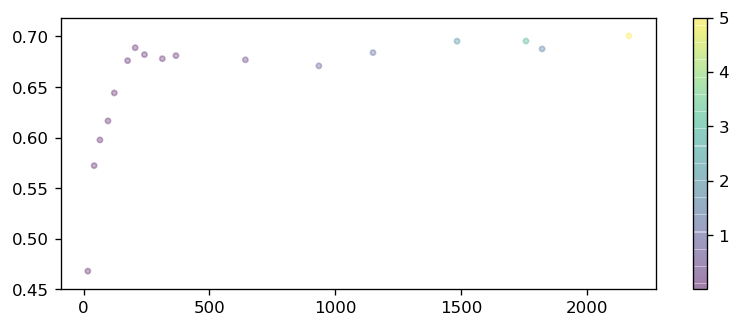

In [114]:
colors = p6_results_cs
sizes = p6_results_cs * 1000

plt.figure(num=None, figsize=(8,3), dpi=120, facecolor='w', edgecolor='k')
# plt.scatter(p6_results_X, p6_results_y, c="royalblue", s=10)
plt.scatter(p6_results_X, p6_results_y, c=colors, s=10, alpha=0.3, cmap='viridis')
plt.colorbar();  # show color scale

# plt.scatter(p6_results_X, p6_results_y)
plt.show()


## P6 ANSWER:

The non-zero weights count for l2 is 107,516 regardless of the value of 'C'.  l2 doesn't force to 0, it allows for high-precision decimals, so this expected.  Using l1 the number of non-zero weights actually increases with the smaller vocabulary. 

The vocabulary and accuracy are possitively correlated up until around vocabulary reaches 175 (C=0.8) and then the accuracy is much more weakly correlated to vocabulary size. 

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Using C=100 resulted in F1: 0.756815935313557


**Predicted Label**: comp.graphics  
**Label**: talk.religion.misc  
**Text**:  
   I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions notice in the book itself
for the precise terms.

Negotiations are currently underway with a Mormon publisher vis-a-vis the
printing and distribution of bound books. (Sorry, I'm out of the wire-bound
"first editions.") I will make another announcement about the availability
of printed copies once everything has been worked out.

FTP information: connect via anonymous ftp to carnot.itc.cmu.edu, then "cd
pub" (you won't see anything at all until you do).

"The Easy-to-Read Book of Mormon" is currently available in postscript and
RTF (rich text format). (ASCII, LaTeX, and other versions can be made
available; contact dba@andrew.cmu.edu for details.) You should be able to
print the postscript file on any postscript printer (such as an Apple
Laserwriter); let dba know if you have any difficulties. (The postscript in
the last release had problems on some printers; this time it should work
better.) RTF is a standard document interchange format that can be read in
by a number of word processors, including Microsoft Word for both the
Macintosh and Windows. If you don't have a postscript printer, you may be
able to use the RTF file to print out a copy of the book.

-r--r--r--  1 dba                   1984742 Apr 27 13:12 etrbom.ps
-r--r--r--  1 dba                   1209071 Apr 27 13:13 etrbom.rtf

For more information about how this project came about, please refer to my
article in the current issue of _Sunstone_, entitled "Delighting in
Plainness: Issues Surrounding a Simple Modern English Book of Mormon."

Send all inquiries and comments to:

    Lynn Matthews Anderson
    5806 Hampton Street
    Pittsburgh, PA 15206  

══════════════════════════════════════════════════════════════════════════════


[5.36799720e+02 1.00567655e+00 3.54467554e+02 1.01664216e+03]


**Predicted Label**: talk.religion.misc  
**Label**: alt.atheism  
**Text**:  
   
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...
  

══════════════════════════════════════════════════════════════════════════════


[558.34207987  72.55328061   3.41703217   1.44550963]


**Predicted Label**: comp.graphics  
**Label**: talk.religion.misc  
**Text**:  
   Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.  

══════════════════════════════════════════════════════════════════════════════


[391.11228784   1.01887085  75.46147904 365.51379347]


**Predicted Label**: alt.atheism  
**Label**: talk.religion.misc  
**Text**:  
    	
If, if, if....  Anyway, the question was if the gun was identifiable, which
it is.

-Tim  

══════════════════════════════════════════════════════════════════════════════


[  1.94421611   4.08186789   4.21218925 304.42213683]


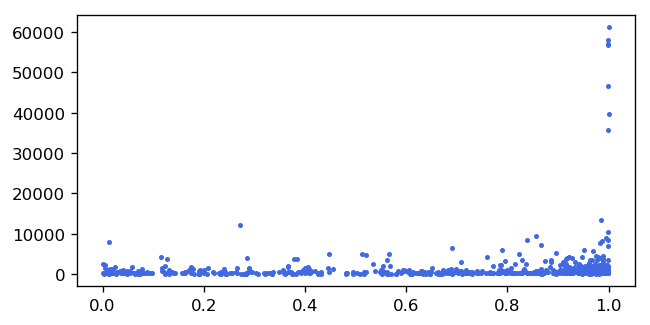

In [171]:
def P7():
### STUDENT START ###
    corpus = train_data 
    y = train_labels
    corpus_test = dev_data
    y_test = dev_labels

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()

    vectorizer_test = TfidfVectorizer(vocabulary=feature_names)
    X_test = vectorizer_test.fit_transform(corpus_test)

    lr = LogisticRegression(C=100, penalty='l2', solver='liblinear', multi_class='ovr', n_jobs=-1)
    lr.fit(X, y)
    lr_y_pred = lr.predict(X_test)
    lr_y_prob = lr.predict_proba(X_test)

    lr_f1 = metrics.f1_score(y_test, lr_y_pred, average="weighted")
    print("Using C={} resulted in F1: {}".format(100, lr_f1))
    
    max_prob = np.max(lr_y_prob)
    R = max_prob / lr_y_prob
    
    """ Get the R for correct labels """
    true_r = []
    true_probs = []
    for i, label in enumerate(y_test):
        true_r.append((R[i][label], i))
        true_probs.append((lr_y_prob[i][label]))
    
    true_r.sort(reverse = True)
    
    for r_label in true_r[:4]:
        pretty_print_message(newsgroups_train.target_names[y_test[r_label[1]]], 
                             corpus_test[r_label[1]], 
                             newsgroups_train.target_names[lr_y_pred[r_label[1]]])
    
    average_len = 0
    lengths = []
    
    for doc in corpus_test:
        average_len += len(doc)
        lengths.append(len(doc))
        
    
    plt.figure(num=None, figsize=(6,3), dpi=120, facecolor='w', edgecolor='k')
    plt.scatter(np.array(true_probs), np.array(lengths), s=4, c='royalblue')
   
## STUDENT END ###
P7()

## P7 ANSWER:

The length of the text seems to hurt the accuracy.   As seen in the scatter plot above, documents with more characters tedn to score better. 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [228]:
from sklearn.feature_extraction import stop_words

def preprocessor(s):
    cleaned_string = s
    cleaned_string = cleaned_string.lower()
    
    # Tokenize numbers
    cleaned_string = re.sub('^([\s\d]+)$', "NUMBER", cleaned_string).strip()
        
    return cleaned_string

def P8():
    global p6_pruned_vocabulary
    corpus = train_data 
    y = train_labels
    corpus_test = test_data
    y_test = test_labels

    x_train = corpus
    y_train = y
    x_devel = corpus_test
    y_devel = y_test
    
    re_pipe  = Pipeline([
        ('cv', TfidfVectorizer(vocabulary = p6_pruned_vocabulary,
            stop_words=ENGLISH_STOP_WORDS,
            preprocessor=preprocessor
            )),
        ('tfidf', TfidfTransformer()),
        ('lr', LogisticRegression(n_jobs   = -1,
            penalty  = 'l2',
            C        = 150.0,
            solver='liblinear',
            multi_class='ovr',
            tol      = .001
            ))
                        ]).fit(x_train, y_train)
    
    re_score = re_pipe.score(   x_devel, y_devel)
    re_preds = re_pipe.predict( x_devel)
    re_f1    = metrics.f1_score(y_devel, re_preds, average = 'weighted')

    print(re_f1)
P8()

0.7496544612957183
